In [31]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import tensorflow as tf

In [32]:
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.models import Sequential
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

In [37]:
from pprint import pprint
FPATHS = dict(
    data={
        "filtered":  "Data/reviews-filtered.csv",
        "processed": "Data/reviews_filtered.joblib",
        "ml": {
            "train": "Data/training-data.joblib",  
            "test": "Data/testing-data.joblib",
            
            "label_encoder":"Data/label-encoder.joblib",
            'target_lookup':"Data/target-lookup-dict.joblib",
            
        },
        "tf": {
            "train_tf": "Data/tf/training_tf",  
            "test_tf": "Data/tf/testing_tf", 
         },           
    },
    models={
        "rf": "models/random_forest/rf-pipe.joblib", 
        "nb": "models/nb/nb-pipe.joblib", 
        "gru": "models/tf/"
    },
    eda = {
        "scattertext": "eda/scattertext.html",
        "lemmas-high": "eda/high_cloud.png",
        'lemmas-low':"eda/low_cloud.png",
        'tokens-high':'high_cloud_tokens.png',
        'tokens-low':'low_cloud_tokens.png',
        'low-freq':'low_freq_dist.png',
        'high-freq':'high_freq_dist.png',
    }
)
pprint(FPATHS)

{'data': {'filtered': 'Data/reviews-filtered.csv',
          'ml': {'label_encoder': 'Data/label-encoder.joblib',
                 'target_lookup': 'Data/target-lookup-dict.joblib',
                 'test': 'Data/testing-data.joblib',
                 'train': 'Data/training-data.joblib'},
          'processed': 'Data/reviews_filtered.joblib',
          'tf': {'test_tf': 'Data/tf/testing_tf',
                 'train_tf': 'Data/tf/training_tf'}},
 'eda': {'high-freq': 'high_freq_dist.png',
         'lemmas-high': 'eda/high_cloud.png',
         'lemmas-low': 'eda/low_cloud.png',
         'low-freq': 'low_freq_dist.png',
         'scattertext': 'eda/scattertext.html',
         'tokens-high': 'high_cloud_tokens.png',
         'tokens-low': 'low_cloud_tokens.png'},
 'models': {'gru': 'models/tf/',
            'nb': 'models/nb/nb-pipe.joblib',
            'rf': 'models/random_forest/rf-pipe.joblib'}}


In [4]:
import os, sys
%load_ext autoreload 
%autoreload 2
import custom_functions as fn

In [38]:
# Using function from Creating a File Structure Lesson
fn.create_directories_from_paths(FPATHS)

In [39]:
# Save the filepaths in a config folder
import os, json
os.makedirs('config/', exist_ok=True)
FPATHS_FILE = 'config/filepaths.json'
with open(FPATHS_FILE, 'w') as f:
    json.dump(FPATHS, f)

In [7]:
# This data has already been cleaned and prepped for modeling.
df = pd.read_csv("Data/reviews_filtered.csv", index_col=0)
df.head()

,review,rating
1,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",1
6,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully...",0
7,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf...,0
15,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (I guess if they don’t end happily, they aren’...",1
20,**_Scream 3’s_ lackluster screenplay and unimaginative kills leave a film that is a bore to watch.**\r\n\r\nThe meta-narrative of trilogies throughout the film does not make up for how abysmal the plot was. This film creates so much lore for the ...,0


In [8]:
# Mapping numeric value with public-facing label
rename_target_map = {0:'Negative', 1:"Positive"}

In [9]:
X = df['review']
y = df['rating'].replace(rename_target_map)

In [10]:
# Train test split
X_train, X_test, y_train_str, y_test_str = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
# Getting unique classes to convert 
class_names = y_train_str.unique()
class_names

array(['Negative', 'Positive'], dtype=object)

In [12]:
from sklearn.preprocessing import LabelEncoder
# Fit the label encoder on unique class names
encoder = LabelEncoder()
encoder.fit(class_names)

LabelEncoder()

In [13]:
# Transform the y_train_str and y_test_str with encoder
y_train = encoder.transform(y_train_str)
y_test = encoder.transform(y_test_str)
y_train[:10]

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 1])

In [14]:
# Extract the class names from the encoder
classes = encoder.classes_
classes

array(['Negative', 'Positive'], dtype=object)

In [15]:
# Get the encoded values for each both classes
class_codes = encoder.transform(classes)
class_codes

array([0, 1])

In [16]:
# Making lookup dictionary to find the encoded label's original name
target_lookup = dict(zip(class_codes,classes ))
target_lookup

{0: 'Negative', 1: 'Positive'}

# Best Model

In [17]:
# We'll try a tfidf vectorizer, more sophisticated than count and weighs words on frequency basis
tfidf_vectorizer = TfidfVectorizer()
# instantiate a vectorizer
tfidf_vectorizer.fit(X_train)

TfidfVectorizer()

In [18]:
# How many words in vocabulary
len(tfidf_vectorizer.vocabulary_)

23156

In [19]:
# Instantiating random forest
clf = RandomForestClassifier(random_state=42)

In [20]:
# Create a pipeline with a vectorizer and classification model.
clf_pipe = Pipeline([('vectorizer', TfidfVectorizer(stop_words='english')),
                     ('clf', RandomForestClassifier(random_state=42))])
clf_pipe

Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       926
           1       1.00      1.00      1.00       888

    accuracy                           1.00      1814
   macro avg       1.00      1.00      1.00      1814
weighted avg       1.00      1.00      1.00      1814



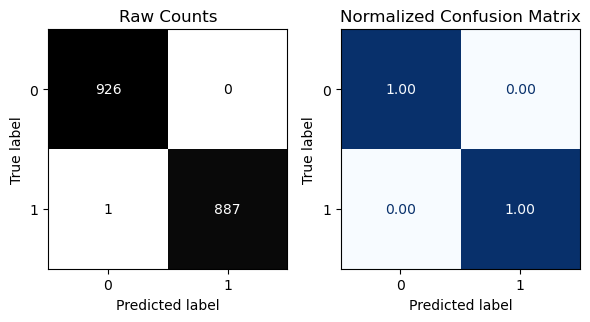


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       298
           1       0.85      0.84      0.84       307

    accuracy                           0.84       605
   macro avg       0.84      0.84      0.84       605
weighted avg       0.84      0.84      0.84       605



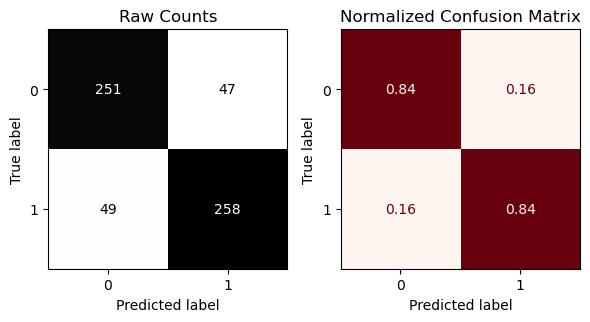

In [21]:
# Fit the model pipeline
clf_pipe.fit(X_train, y_train)
# Evaluate
fn.evaluate_classification(clf_pipe, X_train, y_train, X_test, y_test)

# NLP Model

In [22]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))
# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False)

In [23]:
import math
BATCH_SIZE = 50
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	1693 samples 	(34 batches)
    - val:  	483 samples 	(10 batches)
    - test: 	243 samples 	(5 batches)


In [24]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
## Shuffling just the training data  
train_ds  = train_ds.shuffle(buffer_size = len(train_ds))
# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)
# Confirm len of train_ds
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 34 training batches.
 There are 10 validation batches.
 There are 5 testing batches.


In [25]:
# Define sequence length as a variable for future use
SEQUENCE_LENGTH = 300
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
vectorizer, lookup = fn.make_text_vectorization_layer(train_ds, output_mode='int',output_sequence_length=SEQUENCE_LENGTH, verbose=True)
# Check the size of the vocabulary
VOCAB_SIZE = len(vectorizer.get_vocabulary())


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 300,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 24923}
)


In [26]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)
vectorizer.adapt(ds_texts)
vectorizer.vocabulary_size()

24923

In [27]:
# Define output dimension
EMBED_DIM = 100

# Stacked GRU

In [28]:
def build_gru_model_stack_deep_pool(text_vectorization_layer):
    
    
    MAX_TOKENS = text_vectorization_layer.vocabulary_size()
        
    model = tf.keras.Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])

    # Stack three GrU layers    
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))
    model.add(layers.GRU(128, return_sequences=True))
    model.add(layers.Dropout(.5))         
    # For the final GRU layer, use return_sequences = True for pooling layer
    model.add(layers.GRU(128, return_sequences = True)) 
    model.add(layers.GlobalMaxPooling1D())
    # Output layer
    model.add(layers.Dense(len(classes), 
                              activation='softmax'))

              
    # Define optimizer
    optimizer = optimizers.legacy.Adam()

    # Compile
    model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [29]:
# Include callbacks
def get_callbacks(patience=5, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [30]:
# Build model
model = build_gru_model_stack_deep_pool(vectorizer)

EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
results = fn.evaluate_classification_network(
    model,
    X_test=test_ds, history=history
);

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 300, 100)          2492300   
                                                                 
 gru (GRU)                   (None, 300, 128)          88320     
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 300, 128)          99072     
                                                                 
 dropout_1 (Dropout)         (None, 300, 128)          0         
                                                        

UnimplementedError: Graph execution error:

Detected at node 'Cast_1' defined at (most recent call last):
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Rovidicus\AppData\Local\Temp\ipykernel_11128\3160712359.py", line 5, in <module>
      history = model.fit(
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\keras\engine\training.py", line 1055, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\keras\engine\training.py", line 1149, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\keras\metrics\base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\Rovidicus\anaconda3\envs\dojo-env\lib\site-packages\keras\metrics\base_metric.py", line 676, in update_state
      y_true = tf.cast(y_true, self._dtype)
Node: 'Cast_1'
Cast string to float is not supported
	 [[{{node Cast_1}}]] [Op:__inference_train_function_8910]

# Saving Models

In [ ]:
# Saving the training data
fpath_train  = FPATHS['data']['ml']['train']
joblib.dump([X_train, y_train], fpath_train)
# Saving the testing data
fpath_test = FPATHS['data']['ml']['test']
joblib.dump([X_test, y_test], fpath_test)

In [ ]:
# Save encoder
fpath_encoder = FPATHS['data']['ml']['label_encoder']
joblib.dump(encoder,fpath_encoder)

# Save dictionary
fpath_lookup = FPATHS['data']['ml']['target_lookup']
joblib.dump(target_lookup,fpath_lookup )

In [ ]:
fpath_rf_pipe = FPATHS['models']['rf']
joblib.dump(clf_pipe, fpath_rf_pipe)

In [ ]:
# Save training dataset object
train_ds_fpath = FPATHS['data']['tf']['train_tf']
tf.data.Dataset.save(train_ds, train_ds_fpath)
# Save testing dataset object
test_ds_fpath = FPATHS['data']['tf']['test_tf']
tf.data.Dataset.save(test_ds, test_ds_fpath)